ORES Training Resampling
===

TODO implement resampling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
from tqdm import tqdm
import bz2
import gzip
import json
import re
import hashlib
from datetime import datetime
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [3]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [4]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [6]:
stub_history_dir = os.path.join(derived_data_dir, 'stub-history-all-revisions')
stub_history_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions'

In [7]:
working_dir = os.path.join(derived_data_dir, 'ores-train-resampling')
os.makedirs(working_dir, exist_ok=True)
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/ores-train-resampling'

In [8]:
start_date = datetime.fromisoformat('2014-04-01')
start_timestamp = int(start_date.timestamp())
end_date = datetime.fromisoformat('2020-01-01')
end_timestamp = int(end_date.timestamp())
start_timestamp, end_timestamp

(1396328400, 1577858400)

### Load in all ns3 revisions

First, we use awk to extract only the ns3 revisions from the full revisions file.

In [13]:
rev_ids_filepath = os.path.join(stub_history_dir, 'rev_ids_2010to2019.csv')
rev_ids_ns3_filepath = os.path.join(stub_history_dir, 'rev_ids_2010to2019_ns3.csv')
print(rev_ids_filepath)
print(rev_ids_ns3_filepath)

/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/rev_ids_2010to2019.csv
/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/rev_ids_2010to2019_ns3.csv


In [14]:
!awk -F,  'BEGIN {OFS=","} { if ($2 == "3")  print}' /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/rev_ids_2010to2019.csv > /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/rev_ids_2010to2019_ns3.csv

In [15]:
!wc -l {rev_ids_ns3_filepath}

39429426 /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/rev_ids_2010to2019_ns3.csv


In [59]:
# read in the namespace-3 revisions
start = datetime.now()
df = pd.read_csv(rev_ids_ns3_filepath,
                 header=None, 
                 names=['page_id', 'namespace', 'is_redirect', 'rev_id', 'rev_timestamp', 'user_text', 'user_id', 'is_revert_target', 'is_reverted', 'is_reverting']
)
print(f"{datetime.now() - start}")
len(df)

/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0:00:29.597418


39309254

In [60]:
start = datetime.now()
df = df.sort_values(by='rev_timestamp')
print(f"{datetime.now() - start}")

0:00:16.466559


In [61]:
df.head()

,page_id,namespace,is_redirect,rev_id,rev_timestamp,user_text,user_id,is_revert_target,is_reverted,is_reverting
18080918,20907938,3,0,335202627,1262325609,Philip Stevens,411183,0,0,0
14735690,25638779,3,0,335202628,1262325609,Philip Stevens,411183,0,0,0
12273844,22737741,3,0,335202655,1262325615,XLinkBot,6163802,1,0,0
1080314,24048656,3,0,335202682,1262325624,Bigweeboy,9166188,0,0,0
16147253,2914299,3,0,335202684,1262325624,TonyTheTiger,1426328,0,0,0


### Range analysis

Analyzing the two specific periods during which the ns-3 revision anomaly is observed.

In [37]:
range1_start_timestamp = int(datetime.fromisoformat('2015-03-19').timestamp())
range1_end_timestamp = int(datetime.fromisoformat('2015-03-21').timestamp())

subset = df[(df.rev_timestamp >= range1_start_timestamp)&(df.rev_timestamp <= range1_end_timestamp)]
print(len(subset))

days = [int(datetime.utcfromtimestamp(rt).strftime("%Y%m%d")) for rt in subset.rev_timestamp]
mc = Counter(days)
mc.most_common(10)

537792


[(20150320, 526831), (20150319, 8319), (20150321, 2642)]

In [38]:
Counter(subset.user_text).most_common(10)

[('MediaWiki message delivery', 516152),
 ('ClueBot NG', 1632),
 ('Stefan2', 1171),
 ('Lowercase sigmabot III', 618),
 ('Materialscientist', 386),
 ('HasteurBot', 384),
 ('L235', 308),
 ('DPL bot', 304),
 ('Gilliam', 284),
 ('Onel5969', 277)]

In [39]:
mwmd_subset = subset[subset.user_text == 'MediaWiki message delivery']
len(mwmd_subset) / len(subset)

0.9597613947399738

In [41]:
# notifications are related to a multi-wiki account reunification process
for rev_id in mwmd_subset.sample(n=5).rev_id:
    url = f"https://en.wikipedia.org/w/index.php?diff=prev&oldid={rev_id}"
    print(url)

https://en.wikipedia.org/w/index.php?diff=prev&oldid=652450594
https://en.wikipedia.org/w/index.php?diff=prev&oldid=652154679
https://en.wikipedia.org/w/index.php?diff=prev&oldid=652541631
https://en.wikipedia.org/w/index.php?diff=prev&oldid=652354277
https://en.wikipedia.org/w/index.php?diff=prev&oldid=652669220


In [32]:
range2_start_timestamp = int(datetime.fromisoformat('2015-04-20').timestamp())
range2_end_timestamp = int(datetime.fromisoformat('2015-04-24').timestamp())

subset = df[(df.rev_timestamp >= range2_start_timestamp)&(df.rev_timestamp <= range2_end_timestamp)]
print(len(subset))

days = [int(datetime.utcfromtimestamp(rt).strftime("%Y%m%d")) for rt in subset.rev_timestamp]
mc = Counter(days)
mc.most_common(10)

1068340


[(20150422, 747689),
 (20150421, 208689),
 (20150423, 100223),
 (20150420, 8478),
 (20150424, 3261)]

In [33]:
Counter(subset.user_text).most_common(10)

[('Maintenance script', 511600),
 ('MediaWiki message delivery', 511028),
 ('ClueBot NG', 4054),
 ('Legobot', 1595),
 ('Lowercase sigmabot III', 1223),
 ('Materialscientist', 960),
 ('Winner 42', 857),
 ('I dream of horses', 736),
 ('DPL bot', 706),
 ('Gilliam', 585)]

In [43]:
# 5% of total ns3 revisions in the 2010s were by user 'MediaWiki message delivery'
mwmd_subset = df[df.user_text == 'MediaWiki message delivery']
len(mwmd_subset), len(mwmd_subset) / len(df)

(2158539, 0.054911726383817916)

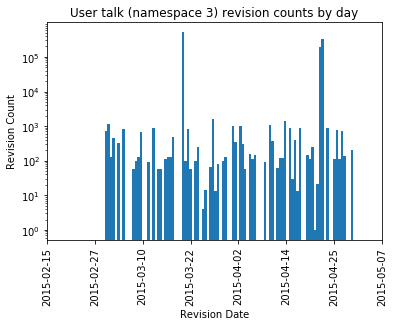

In [45]:
ut_start_timestamp = int(datetime.fromisoformat('2015-03-01').timestamp())
ut_end_timestamp = int(datetime.fromisoformat('2015-05-01').timestamp())

mwmd_subset_window = mwmd_subset[(mwmd_subset.rev_timestamp >= ut_start_timestamp)&(mwmd_subset.rev_timestamp <= ut_end_timestamp)]
plt.hist(mwmd_subset_window.rev_timestamp, bins=100, log=True)

xticks, _ = plt.xticks()
plt.xticks(xticks, 
           [datetime.utcfromtimestamp(xtick).strftime("%Y-%m-%d") for xtick in xticks], 
           rotation='vertical')
plt.title("User talk (namespace 3) revision counts by day")
plt.xlabel("Revision Date")
plt.ylabel("Revision Count")
plt.show()

In [47]:
# over the course of the training window but NOT during the spikes, what's the average number of MassMessage revisions...
ut_start_timestamp = int(datetime.fromisoformat('2014-04-15').timestamp())
ut_end_timestamp = int(datetime.fromisoformat('2015-04-15').timestamp())

mwmd_subset_window = mwmd_subset[(mwmd_subset.rev_timestamp >= ut_start_timestamp)
                                 &(mwmd_subset.rev_timestamp <= ut_end_timestamp)
                                 &((mwmd_subset.rev_timestamp <= range1_start_timestamp)
                                 |(mwmd_subset.rev_timestamp >= range1_end_timestamp))]
len(mwmd_subset_window)

126319

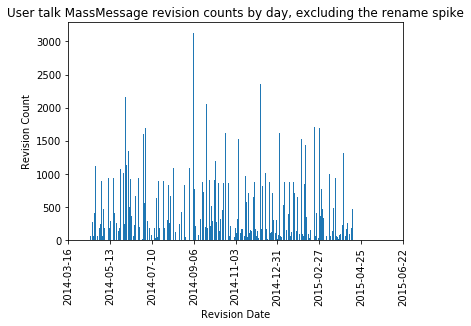

In [51]:
plt.hist(mwmd_subset_window.rev_timestamp, bins=365, log=False)

xticks, _ = plt.xticks()
plt.xticks(xticks, 
           [datetime.utcfromtimestamp(xtick).strftime("%Y-%m-%d") for xtick in xticks], 
           rotation='vertical')
plt.title("User talk MassMessage revision counts by day, excluding the rename spike")
plt.xlabel("Revision Date")
plt.ylabel("Revision Count")
plt.show()

In [52]:
days = [int(datetime.utcfromtimestamp(rt).strftime("%Y%m%d")) for rt in mwmd_subset_window.rev_timestamp]
mc = Counter(days)
mc.most_common(10)

[(20140906, 3132),
 (20141207, 2497),
 (20140924, 2224),
 (20140604, 2167),
 (20150414, 1756),
 (20150227, 1696),
 (20150103, 1621),
 (20141208, 1606),
 (20150327, 1577),
 (20141107, 1530)]

In [54]:
# within the training period, excluding the spike, an everage of 492 MassMessage revisions per day
np.mean(list(mc.values()))

491.5136186770428

### Load and subsample the training data

From the training rev_ids, identify and remove some of the 'MediaWiki message delivery' revs.

In [55]:
revisions_features_filepath = os.path.join(git_root_dir, "data/raw/editquality/datasets/enwiki.labeled_revisions.20k_2015.damaging.tsv")
assert os.path.exists(revisions_features_filepath)

In [56]:
features_df = pd.read_csv(revisions_features_filepath, sep='\t', header=0)
len(features_df)

19348

In [62]:
rev_list = []
revisions_with_cache_filepath = os.path.join(git_root_dir, "data/raw/editquality/datasets/enwiki.labeled_revisions.w_cache.20k_2015.json")
with open(revisions_with_cache_filepath, 'r') as infile:
    for line in infile:
        rev = json.loads(line)
        rev_list.append({
            'rev_id': rev['rev_id'],
            'damaging': rev['damaging'],
            'goodfaith': rev['goodfaith']
        })
train_df = pd.DataFrame(rev_list)
len(train_df)

19348

In [63]:
train_df = pd.concat([train_df, features_df], axis=1)

In [64]:
train_df.head()

,rev_id,damaging,goodfaith,feature.revision.page.is_articleish,feature.revision.page.is_mainspace,feature.revision.page.is_draftspace,feature.log((wikitext.revision.parent.chars + 1)),feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.words>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.uppercase_words>) + 1)),...,feature.english.dictionary.revision.diff.dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_decrease,damaging
0,644933637,False,True,False,False,False,11.487669,9.673949,8.289037,2.890372,...,2.597872,2.597872,0.0,12,12,0,11.027027,11.027027,0.0,False
1,629393521,False,True,True,True,False,9.782336,8.767173,7.884953,3.218876,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
2,655365754,False,True,False,False,False,8.696009,7.963112,6.218600,1.098612,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
3,616502017,False,True,True,True,False,9.205629,8.144969,7.152269,3.496508,...,1.000000,1.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
4,651762922,False,True,False,False,False,7.603898,6.356108,5.323010,2.484907,...,16.596429,16.596429,0.0,7,7,0,5.342857,5.342857,0.0,False


In [70]:
# merge in revision info to the train df
# note this only works for ns3 revisions
train_df = train_df.merge(df, on='rev_id', how='left', validate='one_to_one')
train_df.head()

,rev_id,damaging,goodfaith,feature.revision.page.is_articleish,feature.revision.page.is_mainspace,feature.revision.page.is_draftspace,feature.log((wikitext.revision.parent.chars + 1)),feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.words>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.uppercase_words>) + 1)),...,damaging,page_id,namespace,is_redirect,rev_timestamp,user_text,user_id,is_revert_target,is_reverted,is_reverting
0,644933637,False,True,False,False,False,11.487669,9.673949,8.289037,2.890372,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,629393521,False,True,True,True,False,9.782336,8.767173,7.884953,3.218876,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,655365754,False,True,False,False,False,8.696009,7.963112,6.218600,1.098612,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,616502017,False,True,True,True,False,9.205629,8.144969,7.152269,3.496508,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,651762922,False,True,False,False,False,7.603898,6.356108,5.323010,2.484907,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
mwmd_train_df = train_df[train_df.user_text == 'MediaWiki message delivery']
len(mwmd_train_df), len(mwmd_train_df) / len(train_df)

(269, 0.013903245813520777)

In [73]:
mwmd_train_df_nonspike = mwmd_train_df[(mwmd_train_df.rev_timestamp <= range1_start_timestamp)
                                 |(mwmd_train_df.rev_timestamp >= range1_end_timestamp)]
len(mwmd_train_df_nonspike), len(mwmd_train_df_nonspike) / len(mwmd_train_df)

(53, 0.1970260223048327)

In [75]:
# less than one MassMessage revision per day is included in the sample
len(mwmd_train_df_nonspike) / 365

0.14520547945205478

In [ ]:
# there are few non-spike MassMessage revisions; 80% are from the range
# as the range is a 2-day period, and there are on average less than one MassMessage in the training data per day,
# we will sample a single revision at random from within the range and discard the rest

In [78]:
mwmd_train_df_spike = mwmd_train_df[(mwmd_train_df.rev_timestamp >= range1_start_timestamp)
                                 &(mwmd_train_df.rev_timestamp <= range1_end_timestamp)]
len(mwmd_train_df_spike), len(mwmd_train_df_spike) / len(mwmd_train_df)

(216, 0.8029739776951673)

In [83]:
to_keep = mwmd_train_df_spike.sample(n=1, random_state=365).rev_id
to_discard = set(mwmd_train_df_spike.rev_id)
for rev_id in to_keep:
    to_discard.remove(rev_id)
len(to_discard)

215

In [84]:
# Discard the removed rev_ids from the training data
train_df_downsampled = train_df[~train_df.rev_id.isin(to_discard)]
len(train_df_downsampled), len(train_df) - len(train_df_downsampled)

(19133, 215)

In [86]:
features_df_downsampled = train_df.loc[train_df_downsampled.index, features_df.columns]
features_df_downsampled.shape

(19133, 82)

In [88]:
features_df_downsampled = features_df_downsampled.loc[:,~features_df_downsampled.columns.duplicated()]
features_df_downsampled.shape

(19133, 81)

In [89]:
features_df_downsampled.head()

,feature.revision.page.is_articleish,feature.revision.page.is_mainspace,feature.revision.page.is_draftspace,feature.log((wikitext.revision.parent.chars + 1)),feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.words>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.uppercase_words>) + 1)),feature.log((wikitext.revision.parent.headings + 1)),feature.log((wikitext.revision.parent.wikilinks + 1)),feature.log((wikitext.revision.parent.external_links + 1)),...,feature.english.dictionary.revision.diff.dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_decrease,damaging
0,False,False,False,11.487669,9.673949,8.289037,2.890372,4.804021,5.924256,6.354370,...,2.597872,2.597872,0.0,12,12,0,11.027027,11.027027,0.0,False
1,True,True,False,9.782336,8.767173,7.884953,3.218876,2.639057,3.806662,0.693147,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
2,False,False,False,8.696009,7.963112,6.218600,1.098612,1.098612,4.304065,0.000000,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
3,True,True,False,9.205629,8.144969,7.152269,3.496508,1.945910,4.094345,2.564949,...,1.000000,1.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
4,False,False,False,7.603898,6.356108,5.323010,2.484907,0.693147,2.833213,0.693147,...,16.596429,16.596429,0.0,7,7,0,5.342857,5.342857,0.0,False


In [91]:
downsampled_train_filepath = os.path.join(working_dir, "enwiki.labeled_revisions.20k_2015.downsampled.damaging.tsv")
features_df_downsampled.to_csv(downsampled_train_filepath, sep='\t', header=True, index=False)
print("Finished.")

Finished.


### Train revised classifier with the downsampled features

In [95]:
import sklearn
import sklearn.ensemble
import sklearn.metrics

In [92]:
# read the downsampled training features
downsampled_train_filepath = os.path.join(working_dir, "enwiki.labeled_revisions.20k_2015.downsampled.damaging.tsv")
df = pd.read_csv(downsampled_train_filepath, sep='\t', header=0)
len(df)

19133

In [93]:
df.head()

,feature.revision.page.is_articleish,feature.revision.page.is_mainspace,feature.revision.page.is_draftspace,feature.log((wikitext.revision.parent.chars + 1)),feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.words>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.uppercase_words>) + 1)),feature.log((wikitext.revision.parent.headings + 1)),feature.log((wikitext.revision.parent.wikilinks + 1)),feature.log((wikitext.revision.parent.external_links + 1)),...,feature.english.dictionary.revision.diff.dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_decrease,damaging
0,False,False,False,11.487669,9.673949,8.289037,2.890372,4.804021,5.924256,6.354370,...,2.597872,2.597872,0.0,12,12,0,11.027027,11.027027,0.0,False
1,True,True,False,9.782336,8.767173,7.884953,3.218876,2.639057,3.806662,0.693147,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
2,False,False,False,8.696009,7.963112,6.218600,1.098612,1.098612,4.304065,0.000000,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
3,True,True,False,9.205629,8.144969,7.152269,3.496508,1.945910,4.094345,2.564949,...,1.000000,1.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
4,False,False,False,7.603898,6.356108,5.323010,2.484907,0.693147,2.833213,0.693147,...,16.596429,16.596429,0.0,7,7,0,5.342857,5.342857,0.0,False


In [94]:
# only 3.9% of the reverts in this set are damaging
np.sum(df.damaging) / len(df)

0.03914702346730779

In [96]:
# shuffle the data
df = df.sample(frac=1)

In [97]:
# define the classifier based on the enwiki tuning report
# hyperparameters set from: https://github.com/wikimedia/editquality/blob/master/tuning_reports/enwiki.damaging.md
clf = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features='log2', 
    max_depth=5
)

In [98]:
kf = sklearn.model_selection.KFold(n_splits=5)
train_accs = []
test_accs = []
roc_auc_list = []
for train_idx, test_idx in kf.split(df):
    train = df.loc[train_idx]
    test = df.loc[test_idx]
    
    # train the model
    md = clf.fit(train.iloc[:,:-1], train.iloc[:,-1])
    
    # predict with the model
    y_pred_train = md.predict(train.iloc[:,:-1])
    y_pred_test = md.predict(test.iloc[:,:-1])
    y_pred_test_proba = md.predict_proba(test.iloc[:,:-1])[:,1]
    
    # compute metrics
    acc_train = np.sum(y_pred_train == train.damaging) / len(y_pred_train)
    acc_test = np.sum(y_pred_test == test.damaging) / len(y_pred_test)
    roc_auc = sklearn.metrics.roc_auc_score(test.damaging, y_pred_test_proba)
    
    # save and print metrics
    train_accs.append(acc_train)
    test_accs.append(acc_test)
    roc_auc_list.append(roc_auc)
    print(f"Train: {acc_train*100:.3f}%; test: {acc_test*100:.3f}%; test ROC AUC: {roc_auc:.4f}")
print(f"CV train accuracy: {np.mean(train_accs)*100:.3f}%; CV test accuracy: {np.mean(test_accs)*100:.3f}%; test ROC AUC: {np.mean(roc_auc_list):.4f}")

Train: 97.570%; test: 96.394%; test ROC AUC: 0.9120
Train: 97.400%; test: 96.812%; test ROC AUC: 0.9430
Train: 97.517%; test: 96.760%; test ROC AUC: 0.9221
Train: 97.459%; test: 96.916%; test ROC AUC: 0.9330
Train: 97.531%; test: 96.628%; test ROC AUC: 0.9414
CV train accuracy: 97.495%; CV test accuracy: 96.702%; test ROC AUC: 0.9303


Accuracy and ROC AUC results match those achieved on the non-downsampled data.

In [99]:
# train a classifier on the full data
md = clf.fit(df.iloc[:,:-1], df.iloc[:,-1])
acc_train = np.sum(md.predict(df.iloc[:,:-1]) == df.damaging) / len(df)
acc_train

0.9744943291694977

Now we'll use a classifier trained on the full data to classify sample1 points.

In [101]:
# read in the sample dataframe
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample1_filepath = os.path.join(revision_sample_dir, 'sample1_1M.pkl')
rev_df = pd.read_pickle(sample1_filepath)
len(rev_df)

1000000

In [102]:
# read in the ORES scores
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample1_filepath = os.path.join(revision_sample_dir, 'sample1_ores_scores.csv')
ores_df = pd.read_csv(sample1_filepath, header=None, names=['rev_id', 'damaging_prob', 'damaging_pred', 'goodfaith_prob', 'goodfaith_pred'])
len(ores_df)

1000000

In [103]:
rev_df = pd.merge(rev_df, ores_df, on='rev_id', how='inner')
len(rev_df)

1000000

In [107]:
# load in the features
labeled_revs_dir = os.path.join(derived_data_dir, 'labeled-revs')
sample1_features_filepath = os.path.join(labeled_revs_dir, 'sample1.mock.damaging.tsv')
sample1_feature_df = pd.read_csv(sample1_features_filepath, header=0, sep='\t')
sample1_feature_df.shape

(458449, 81)

In [108]:
sample1_feature_df = sample1_feature_df.drop(columns='damaging')
sample1_feature_df.shape

(458449, 80)

In [109]:
sample1_cache_df = None
rev_list = []
revisions_with_cache_filepath = os.path.join(labeled_revs_dir, "sample1.mock.w_cache.json")
with open(revisions_with_cache_filepath, 'r') as infile:
    for line in infile:
        rev = json.loads(line)
        rev_list.append({
            'rev_id': rev['rev_id'],
            'damaging': rev['damaging'],
            'goodfaith': rev['goodfaith']
        })
sample1_cache_df = pd.DataFrame(rev_list)
len(sample1_cache_df)

458449

In [110]:
sample1_identified_feature_df = pd.concat([sample1_cache_df, sample1_feature_df], axis=1)

In [111]:
# now, apply the classifier to the sample so that predictions can be compared to ORES
rev_df = pd.merge(rev_df, sample1_identified_feature_df, on='rev_id', how='inner')
len(rev_df)

458449

In [125]:
rev_df = rev_df[rev_df.damaging_prob != -1]
rev_df.shape

(458340, 101)

In [126]:
rev_df.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting,is_sample_eligible,prev_rev_id,next_rev_id,prev_rev_timestamp,...,feature.english.dictionary.revision.diff.dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_decrease,downsampled_damaging_prob
0,9516095,846835190,1529576038,0,0,0,True,846835009,850539656,1529575914,...,0.734954,0.734954,0.000000,4,4,0,3.500000,3.500000,0.0,0.005383
1,876872,923997118,1572595746,0,0,0,True,923211396,924618182,1572162918,...,-0.500000,0.000000,-0.500000,0,0,0,0.000000,0.000000,0.0,0.128249
2,53465104,867368228,1541425108,0,0,0,True,867366487,867663184,1541423455,...,-3.643590,0.000000,-3.643590,-1,0,-1,-1.000000,0.000000,-1.0,0.060454
3,60096152,888337768,1552936050,0,0,0,True,888337457,888338754,1552935890,...,2.316390,3.405428,-1.089037,9,9,0,6.012659,6.012659,0.0,0.003914
4,28063274,917010365,1569117229,0,0,0,True,915190631,-1,1568247118,...,1.333333,2.333333,-1.000000,0,1,-1,-0.909091,0.090909,-1.0,0.005864


In [128]:
start = datetime.now()
downsampled_damaging_prob = md.predict_proba(rev_df.loc[:,sample1_feature_df.columns])
rev_df.loc[:,'downsampled_damaging_prob'] = downsampled_damaging_prob[:,1]
print(f"{datetime.now() - start}")

0:00:14.511623


/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Analyze and compare the predictions made by the two models

In [163]:
# the two models diverge substantially in the degree to which they predict that revisions are damaging
# it seems likely that the normal model over-predicts Damaging revisions, whereas the downsampled model may underpredict...
np.sum(rev_df.damaging_prob >= 0.5) / len(rev_df), np.sum(rev_df.downsampled_damaging_prob >= 0.5) / len(rev_df)

(0.10187197277130515, 0.02025570537155823)

/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


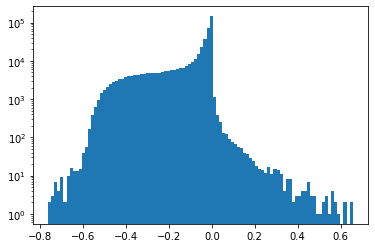

In [130]:
rev_df['damaging_prob_delta'] = rev_df.downsampled_damaging_prob - rev_df.damaging_prob
plt.hist(rev_df.damaging_prob_delta, bins=100, log=True)
plt.show()

In [177]:
large_damaging_prob_delta_count = np.sum(rev_df.damaging_prob_delta >= 0.1)
print(f"{large_damaging_prob_delta_count} / {len(rev_df)} ({large_damaging_prob_delta_count / len(rev_df) * 100:.2f}%) revisions shifted +0.1 or more")

513 / 458340 (0.11%) revisions shifted +0.1 or more


In [178]:
large_damaging_prob_delta_count = np.sum(rev_df.damaging_prob_delta <= -0.1)
print(f"{large_damaging_prob_delta_count} / {len(rev_df)} ({large_damaging_prob_delta_count / len(rev_df) * 100:.2f}%) revisions shifted -0.1 or more")

136718 / 458340 (29.83%) revisions shifted -0.1 or more


In [180]:
small_damaging_prob_delta_count = np.sum(abs(rev_df.damaging_prob_delta) <= 0.1)
print(f"{small_damaging_prob_delta_count} / {len(rev_df)} ({small_damaging_prob_delta_count / len(rev_df) * 100:.2f}%) revisions shifted less than +/-0.1")

321109 / 458340 (70.06%) revisions shifted less than +/-0.1


In [184]:
small_change_eta = 0.01
small_damaging_prob_delta_count = np.sum(abs(rev_df.damaging_prob_delta) <= small_change_eta)
print(f"{small_damaging_prob_delta_count} / {len(rev_df)} ({small_damaging_prob_delta_count / len(rev_df) * 100:.2f}%) revisions shifted less than {small_change_eta}")

140305 / 458340 (30.61%) revisions shifted less than 0.01


In [147]:
rev_df.shape

(458340, 102)

In [140]:
# Construct colorplot for matrix plotting
# This sets the colormap that will be used for the matrix plots below
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
new_cmap = truncate_colormap(plt.cm.Purples, 0, 0.6)

In [138]:
# while few shifted a large amount, one relevant question is: how many change buckets?
# i.e. https://en.wikipedia.org/wiki/Special:ORESModels
likelygood_threshold = 0.329
verylikelybad_threshold = 0.919

rev_counts = np.zeros((2, 3))
for i in [0, 1]:
    if i == 0:
        probs = rev_df.damaging_prob
    else:
        probs = rev_df.downsampled_damaging_prob
    for j in [0, 1, 2]:
        ores_bucket_idx = None
        if j == 0:  # verylikelygood
            ores_bucket_idx = probs <= likelygood_threshold
        elif j == 1:  # neither
            ores_bucket_idx = (probs > likelygood_threshold)&(probs < verylikelybad_threshold)
        elif j == 2:  # likelybad
            ores_bucket_idx = probs >= verylikelybad_threshold
        rev_counts[i,j] = np.sum(ores_bucket_idx)
rev_counts

array([[376737.,  78865.,   2738.],
       [439306.,  18174.,    860.]])

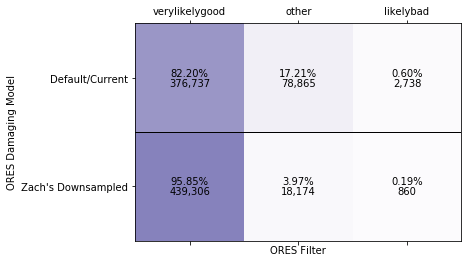

In [148]:
# ORES model X ORES prediction bucket
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

rev_pcts = rev_counts.copy()
for i in range(2):
    model_total = rev_pcts[i,:].sum()
    rev_pcts[i,:] = rev_pcts[i,:] / model_total * 100
ax.matshow(rev_pcts, cmap=new_cmap)
plt.xlabel("ORES Filter")
plt.ylabel("ORES Damaging Model")
ores_filter_labels = [f"{display_label}"
               for i, display_label
               in enumerate(['verylikelygood', 'other', 'likelybad'])
              ]
model_labels = [f"{display_label}"
               for i, display_label
               in enumerate(['Default/Current', 'Zach\'s Downsampled'])
              ]
plt.xticks(ticks=[0, 1, 2], labels=ores_filter_labels)
plt.yticks(ticks=[0, 1], labels=model_labels)
for i in range(2):  # which model
    for j in range(3):  # ores filter
        pct = f"{rev_pcts[i, j]:.2f}%"
        plt.text(j, i, pct, verticalalignment='bottom', horizontalalignment='center')
        count = f"{int(rev_counts[i, j]):,}"
        plt.text(j, i, count, verticalalignment='top', horizontalalignment='center')
plt.axhline(0.5, color='black', linewidth=1)

plt.show()

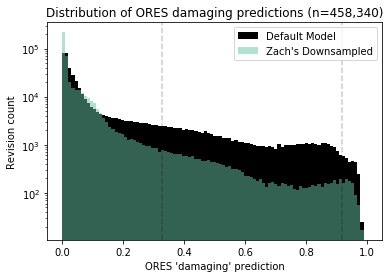

In [162]:
cmap = matplotlib.cm.Set2
plt.hist(rev_df.damaging_prob, bins=np.linspace(0, 1, num=100), color='black', log=True, label='Default Model')
plt.hist(rev_df.downsampled_damaging_prob, bins=np.linspace(0, 1, num=100), log=True, color=cmap(0), alpha=0.5, label='Zach\'s Downsampled')
plt.axvline(likelygood_threshold, linestyle='--', color='black', alpha=0.2)
plt.axvline(verylikelybad_threshold, linestyle='--', color='black', alpha=0.2)
plt.title(f"Distribution of ORES damaging predictions (n={len(rev_df):,})")
plt.xlabel("ORES 'damaging' prediction")
plt.ylabel("Revision count")
plt.legend()
plt.show()

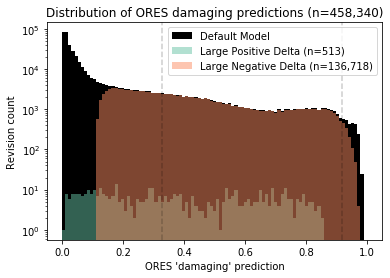

In [169]:
cmap = matplotlib.cm.Set2
plt.hist(rev_df.damaging_prob, bins=np.linspace(0, 1, num=100), color='black', log=True, label='Default Model')
lpd_df = rev_df[rev_df.downsampled_damaging_prob - rev_df.damaging_prob >= 0.1]
plt.hist(lpd_df.damaging_prob, bins=np.linspace(0, 1, num=100), color=cmap(0), alpha=0.5, log=True, label=f'Large Positive Delta (n={len(lpd_df):,})')
lnd_df = rev_df[rev_df.damaging_prob - rev_df.downsampled_damaging_prob >= 0.1]
plt.hist(lnd_df.damaging_prob, bins=np.linspace(0, 1, num=100), color=cmap(0.2), alpha=0.5, log=True, label=f'Large Negative Delta (n={len(lnd_df):,})')
plt.axvline(likelygood_threshold, linestyle='--', color='black', alpha=0.2)
plt.axvline(verylikelybad_threshold, linestyle='--', color='black', alpha=0.2)
plt.title(f"Distribution of ORES damaging predictions (n={len(rev_df):,})")
plt.xlabel("ORES 'damaging' prediction")
plt.ylabel("Revision count")
plt.legend()
plt.show()

In [192]:
# for annotation, write out the small set of revisions with a large increase in Damaging probability
large_damaging_prob_delta_subset = rev_df[rev_df.damaging_prob_delta >= 0.1]
large_damaging_prob_delta_filepath = os.path.join(working_dir, "large_damaging_prob_delta.csv")
with open(large_damaging_prob_delta_filepath, 'w') as outfile:
    outfile.write("page_id,rev_id,rev_timestamp,rev_date,damaging_prob,downsampled_damaging_prob,damaging_prob_delta,diff_url\n")
    for t in large_damaging_prob_delta_subset.sample(frac=1, random_state=0).itertuples():
        url = f"https://en.wikipedia.org/wiki/?diff={t.rev_id}"
        rev_date = datetime.utcfromtimestamp(t.rev_timestamp).strftime("%Y-%m-%d")
        line = f"{t.page_id},{t.rev_id},{t.rev_timestamp},{rev_date},{t.damaging_prob},{t.downsampled_damaging_prob},{t.damaging_prob_delta},{url}\n"
        outfile.write(line)

In [201]:
# write out a sample of revisions that changed classifications
newly_damaging = rev_df[(rev_df.damaging_prob < 0.5)&(rev_df.downsampled_damaging_prob >= 0.5)]
newly_not_damaging = rev_df[(rev_df.damaging_prob >= 0.5)&(rev_df.downsampled_damaging_prob < 0.5)]
print(f"Identified {len(newly_damaging)} newly-damaging revisions and {len(newly_not_damaging)} no longer considered damaging.")
subset = pd.concat((newly_damaging.sample(n=50), newly_not_damaging.sample(n=50)))
print(len(subset))

sample_subset_filepath = os.path.join(working_dir, f"sample1_changed_classification_random100.csv")
with open(sample_subset_filepath, 'w') as outfile:
    outfile.write("page_id,rev_id,rev_timestamp,rev_date,damaging_prob,downsampled_damaging_prob,damaging_prob_delta,diff_url\n")
    for t in subset.itertuples():
        url = f"https://en.wikipedia.org/wiki/?diff={t.rev_id}"
        rev_date = datetime.utcfromtimestamp(t.rev_timestamp).strftime("%Y-%m-%d")
        line = f"{t.page_id},{t.rev_id},{t.rev_timestamp},{rev_date},{t.damaging_prob},{t.downsampled_damaging_prob},{t.damaging_prob_delta},{url}\n"
        outfile.write(line)

Identified 140 newly-damaging revisions and 37548 no longer considered damaging.
100


In [200]:
# write out a completely random sample of the revisions for annotation
n = 100
sample_subset_filepath = os.path.join(working_dir, f"sample1_random{n}.csv")
with open(sample_subset_filepath, 'w') as outfile:
    outfile.write("page_id,rev_id,rev_timestamp,rev_date,damaging_prob,downsampled_damaging_prob,damaging_prob_delta,diff_url\n")
    subset = rev_df.sample(n=n, random_state=2)
    for t in subset.itertuples():
        url = f"https://en.wikipedia.org/wiki/?diff={t.rev_id}"
        rev_date = datetime.utcfromtimestamp(t.rev_timestamp).strftime("%Y-%m-%d")
        line = f"{t.page_id},{t.rev_id},{t.rev_timestamp},{rev_date},{t.damaging_prob},{t.downsampled_damaging_prob},{t.damaging_prob_delta},{url}\n"
        outfile.write(line)